ℹ 🎐  PIP Spectrum for a single leg. For info e comment see this notebook [here](https://colab.research.google.com/drive/14xhCqPQ19MInd8xqj5F08HaDuu04neBX?hl=it#scrollTo=Ex9COCQDaQdn)

In [1]:
!pip install pybullet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 6.4 MB/s eta 0:00:00


In [2]:
#you can enable the GPU by changing the runtime
import os
os.environ['MESA_GL_VERSION_OVERRIDE'] = '3.3'
os.environ['MESA_GLSL_VERSION_OVERRIDE'] = '330'
import pybullet as p
import pybullet_data as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pylab
from google.colab import widgets
import random
import time

p.connect(p.DIRECT)
#allow to find the assets (URDF, obj, textures etc)
p.setAdditionalSearchPath(pd.getDataPath())

#optionally enable GPU for faster rendering in pybullet.getCameraImage
enableGPU = False
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
import GPUtil as GPU
import sys
# Get all device ids and their processing and memory utiliazion
# (deviceIds, gpuUtil, memUtil) = GPU.getGPUs()

# Print os and python version information
print('OS: ' + sys.platform)
print(sys.version)

# Print package name and version number
print(GPU.__name__ + ' ' + GPU.__version__)

# Show the utilization of all GPUs in a nice table
GPU.showUtilization()

# Show all stats of all GPUs in a nice table
GPU.showUtilization(all=True)

# NOTE: If all your GPUs currently have a memory consumption larger than 1%,
# this step will fail. It's not a bug! It is intended to do so, if it does not
# find an available GPU.
GPUs = GPU.getGPUs()
numGPUs = len(GPU.getGPUs())
print("numGPUs=",numGPUs)
if numGPUs > 0:
  enableGPU = True
eglPluginId = -1
if enableGPU:
  import pkgutil
  egl = pkgutil.get_loader('eglRenderer')
  if (egl):
    eglPluginId = p.loadPlugin(egl.get_filename(), "_eglRendererPlugin")
  else:
    eglPluginId = p.loadPlugin("eglRendererPlugin")

if eglPluginId>=0:
  print("Using GPU hardware (eglRenderer)")
else:
  print("using CPU renderer (TinyRenderer)")

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=c7eb274691c4fd1cf094b54c1d2f3aca3a8ef48f45f0fe742d7913f3e4f506f9
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
OS: linux
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
GPUtil 1.4.0
| ID | GPU | MEM |
------------------
| ID | Name | Serial | UUID || GPU temp. | GPU util. | Memory util. || Memory total | Memory used | Memory free || Display mode | Display active |
--------------------------------------------------------------------------------------------------------------------------------------------------
numGPUs= 0
using CPU renderer (TinyRenderer)


In [3]:
!git clone https://github.com/Gaianeve/Real_Mega_Fufi.git

Cloning into 'Real_Mega_Fufi'...
remote: Enumerating objects: 563, done.
remote: Counting objects: 100% (384/384), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 563 (delta 250), reused 184 (delta 115), pack-reused 179 (from 1)
Receiving objects: 100% (563/563), 6.16 MiB | 6.01 MiB/s, done.
Resolving deltas: 100% (335/335), done.


In [4]:
%cd Real_Mega_Fufi/Robot/1LegTrail/

/content/Real_Mega_Fufi/Robot/1LegTrail


In [5]:
##!! THIS IS THE RIGHT ORDER, DO NOT TOUCH IT OTHERWISE SIMULATION WONT WORK
#reset simulation
p.resetSimulation()
p.configureDebugVisualizer(p.COV_ENABLE_GUI)
#tell him to slide freely on the ground plane
useFixedBase = False
flags = p.URDF_INITIALIZE_SAT_FEATURES

plane_pos = [0,0,-0.1]
plane = p.loadURDF("plane.urdf", plane_pos, flags = flags, useFixedBase=useFixedBase)

# position of the base of the model
PIP_position = [0,0,0.1]
orientation  = [0,0,0]
PIP_orientation = p.getQuaternionFromEuler(orientation)
PIPPA_id = p.loadURDF("PIPPA_oneleg.urdf",basePosition = PIP_position,baseOrientation = PIP_orientation,\
                      useFixedBase=useFixedBase)


In [6]:
link_name_to_index = {p.getBodyInfo(PIPPA_id)[0].decode('UTF-8'):-1,}

for id in range(p.getNumJoints(PIPPA_id)):
  name = p.getJointInfo(PIPPA_id, id)[12].decode('UTF-8')
  link_name_to_index[name] = id

print(link_name_to_index)

{'Link_colonna': -1, 'Giunto_Link': 0, 'Gamba_Link': 1}


In [7]:
# AL 6082 (Alluminio)
lateralFriction_Al = 0.3
restitution_Al = 0.2
rollingFriction_Al = 0.001
spinningFriction_Al = 0.01
linearDamping_Al = 0.04
angularDamping_Al = 0.1
contactStiffness_Al = 3e6
contactDamping_Al = 800

# AISI 304 (Acciaio Inox)
lateralFriction_AISI = 0.4
restitution_AISI = 0.1
rollingFriction_AISI = 0.001
spinningFriction_AISI= 0.05
linearDamping_AISI = 0.03
angularDamping_AISI = 0.1
contactStiffness_AISI = 8e6
contactDamping_AISI = 1500

# Acciaio Maraging (Maragià per gli amici)
lateralFriction_Mar = 0.3
restitution_Mar = 0.2
rollingFriction_Mar = 0.001
spinningFriction_Mar = 0.02
linearDamping_Mar = 0.04
angularDamping_Mar = 0.15
contactStiffness_Mar = 3e6
contactDamping_Mar = 800

In [8]:
link_indices_Al = link_name_to_index['Gamba_Link']

link_indices_AISI = link_name_to_index['Link_colonna']

link_indices_Mar = link_name_to_index['Giunto_Link']

# Al 6082

p.changeDynamics(PIPPA_id, link_indices_Al, lateralFriction=lateralFriction_Al,\
                  restitution=restitution_Al, \
                  spinningFriction= spinningFriction_Al, rollingFriction= rollingFriction_Al,\
                  linearDamping=linearDamping_Al, angularDamping=angularDamping_Al,\
                  contactStiffness = contactStiffness_Al,contactDamping = contactDamping_Al)
# AISI 304

p.changeDynamics(PIPPA_id, link_indices_AISI, lateralFriction=lateralFriction_AISI,\
                  restitution=restitution_AISI, \
                  spinningFriction= spinningFriction_AISI, rollingFriction= rollingFriction_AISI,\
                  linearDamping=linearDamping_AISI, angularDamping=angularDamping_AISI,\
                  contactStiffness = contactStiffness_AISI, contactDamping = contactDamping_AISI)
# Maragià

p.changeDynamics(PIPPA_id, link_indices_Mar, lateralFriction=lateralFriction_Mar,\
                  restitution=restitution_Mar, \
                  spinningFriction= spinningFriction_Mar, rollingFriction= rollingFriction_Mar,\
                  linearDamping=linearDamping_Mar, angularDamping=angularDamping_Mar,\
                  contactStiffness = contactStiffness_Mar, contactDamping = contactDamping_Mar)

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

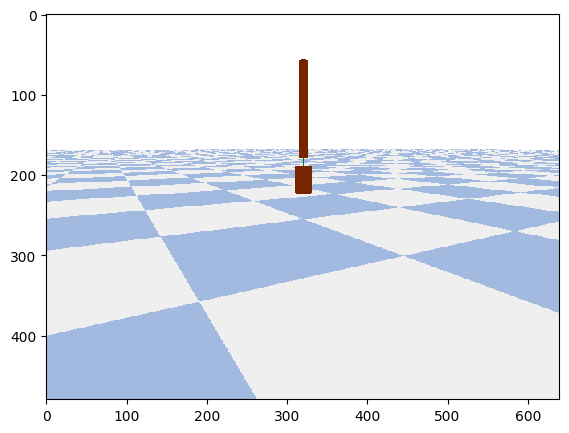

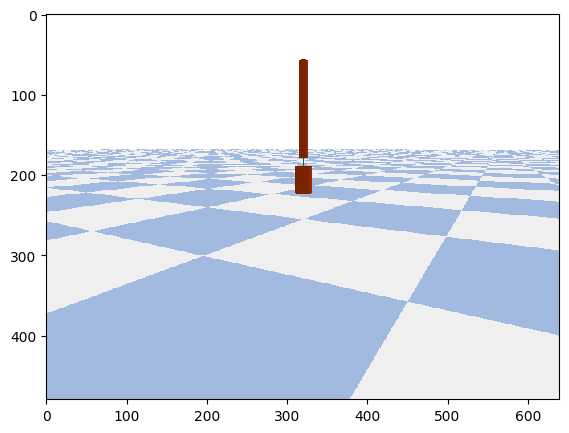

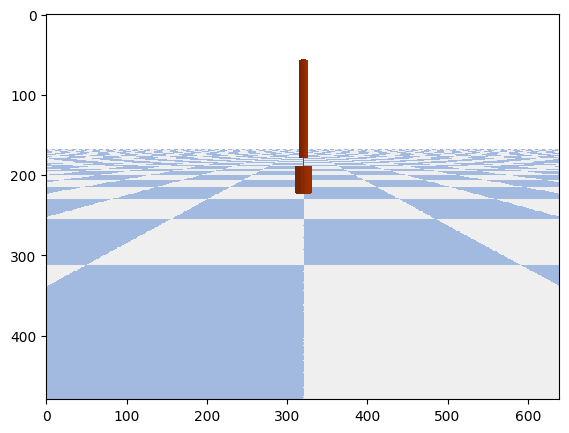

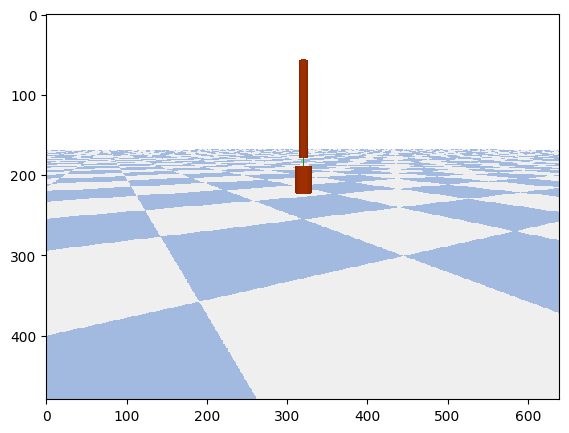

In [9]:
camTargetPos = [0, 0, 0]
cameraUp = [0, 0, 1]
cameraPos = [1, 1, 1]
p.setGravity(0, 0, -10)
from google.colab import widgets
import numpy as np
import random
import time
from matplotlib import pylab
grid = widgets.Grid(2, 2)
yaw = 0
for r in range(2):
  for c in range(2):
    yaw += 60
    with grid.output_to(r, c):
      grid.clear_cell()
      pylab.figure(figsize=(10, 5))
      pitch = -10.0
      roll = 0
      upAxisIndex = 2
      camDistance = 2.5
      pixelWidth = 640
      pixelHeight = 480
      nearPlane = 0.01
      farPlane = 100
      fov = 60
      viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                  roll, upAxisIndex)
      aspect = pixelWidth / pixelHeight
      projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

      img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
      w = img_arr[0]  #width of the image, in pixels
      h = img_arr[1]  #height of the image, in pixels
      rgb = img_arr[2]  #color data RGB
      dep = img_arr[3]  #depth data
      print("w=",w,"h=",h)
      np_img_arr = np.reshape(rgb, (h, w, 4))
      np_img_arr = np_img_arr * (1. / 255.)
      pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")


In [10]:
column_position, _  = p.getBasePositionAndOrientation(PIPPA_id)
print('Column:', column_position)

joint_position = p.getLinkState(PIPPA_id, link_name_to_index['Giunto_Link'])[0]
print('Joint:', joint_position)


Column: (0.0, 0.0, 0.1)
Joint: (0.0, 0.0, 0.28500000000000003)


🛑 🛑 🛑 posObj always refers to the link’s local coordinate frame, even if the force itself is specified in the global frame using flags=p.WORLD_FRAME. So `posObj = [0,0,0] `is the center of mass, while `posObj = [0,0,0.5]` means apply force on distance 0.05 in z from the center of mass.

As long as we are concerned, we have to set `flags=p.WORLD_FRAME`

In [11]:
#Force to be applied
force_module = np.array([0.1,0,0])
force_position = np.array([0,0,0.0]) #means apply in the center
p.applyExternalForce(
    objectUniqueId=PIPPA_id,linkIndex = link_name_to_index['Link_colonna'],forceObj=force_module, \
    posObj=force_position, flags=p.LINK_FRAME)

leg_positions_x, leg_positions_y, leg_position_z = [], [], []

In [ ]:
sampling_time = 180#s
sampling_frequency = 1/100
num_points = sampling_time*sampling_frequency

p.setTimeStep(0.01)

for _ in range(1000):
    p.stepSimulation()
    leg_position = p.getLinkState(PIPPA_id, link_name_to_index['Gamba_Link'])[0]
    leg_positions_x.append(leg_position[0])
    leg_positions_y.append(leg_position[1])
    leg_position_z.append(leg_position[2])
    grid = widgets.Grid(2, 2)
    yaw = 0
    for r in range(2):
      for c in range(2):
        yaw += 60
        with grid.output_to(r, c):
          grid.clear_cell()
          pylab.figure(figsize=(10, 5))
          pitch = -10.0
          roll = 0
          upAxisIndex = 2
          camDistance = 2.5
          pixelWidth = 640
          pixelHeight = 480
          nearPlane = 0.01
          farPlane = 100
          fov = 60
          viewMatrix = p.computeViewMatrixFromYawPitchRoll(camTargetPos, camDistance, yaw, pitch,
                                                                      roll, upAxisIndex)
          aspect = pixelWidth / pixelHeight
          projectionMatrix = p.computeProjectionMatrixFOV(fov, aspect, nearPlane, farPlane)

          img_arr = p.getCameraImage(pixelWidth,pixelHeight,viewMatrix,projectionMatrix)
          w = img_arr[0]  #width of the image, in pixels
          h = img_arr[1]  #height of the image, in pixels
          rgb = img_arr[2]  #color data RGB
          dep = img_arr[3]  #depth data
          print("w=",w,"h=",h)
          np_img_arr = np.reshape(rgb, (h, w, 4))
          np_img_arr = np_img_arr * (1. / 255.)
          pylab.imshow(np_img_arr, interpolation='none', animated=True, label="pybullet")



,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<ipython-input-12-bc04b6b5b2d6>:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  pylab.figure(figsize=(10, 5))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

,
,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

w= 640 h= 480


<IPython.core.display.Javascript object>

In [ ]:
#plotting positions
plt.figure('Leg positions')
plt.plot(leg_positions_x, label='x')
plt.plot(leg_positions_y, label='y')
plt.plot(leg_position_z, label='z')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(0,200)
plt.show()

In [ ]:
plt.figure('xz motion')
plt.plot(leg_positions_x, leg_positions_y, label = 'leg1')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure('3D motion', figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(leg_positions_x, leg_positions_y, leg_position_z, label = 'leg 1')
plt.legend()
plt.minorticks_on()
plt.show()